In [184]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import base64
import pandas as pd
import json
import seaborn as sns
from random import randint, uniform
from tqdm import tqdm
from collections import Counter
from itertools import permutations, product
from imblearn.under_sampling import RandomUnderSampler
import albumentations as A
import random

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from tensorflow.keras.datasets import mnist
sys.path.append('../src/inference')
from utils import *

data_dir = '../data'
model_dir = '../model'

# MNIST dataset

In [185]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

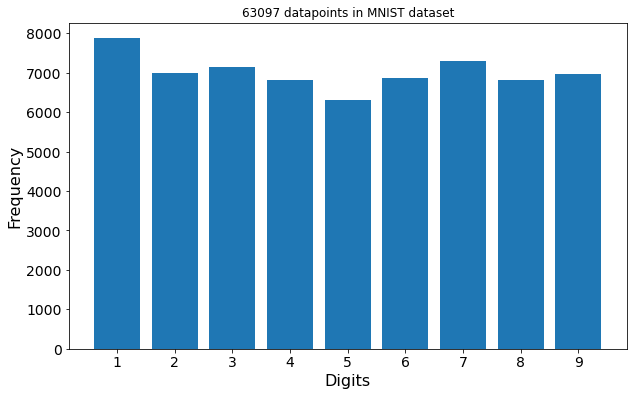

In [186]:
data_mnist = np.concatenate((X_train_mnist, X_test_mnist), axis=0)
data_mnist = data_mnist.reshape(data_mnist.shape[0],-1)
target_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

non_zero = np.where(target_mnist!=0)[0]
data_mnist = data_mnist[non_zero]
target_mnist = target_mnist[non_zero]

col = np.unique(target_mnist)
digits_no = len(col)
counts_mnist = Counter(target_mnist)

plt.figure(figsize=(10,6))
plt.bar(counts_mnist.keys(), counts_mnist.values(), width = 0.8)
plt.tick_params(labelsize = 14)
plt.xticks(list(counts_mnist.keys()))
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title('%s datapoints in MNIST dataset'%(target_mnist.shape[0]))

plt.show()

# Resampling of MNIST dataset to train/val/test format

In [4]:
X_train, X, y_train, y = train_test_split(data_mnist, target_mnist, test_size = 0.2, stratify=target_mnist)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, stratify = y)

print(X_train.shape,y_train.shape,X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(56000, 784) (56000,) (7000, 784) (7000, 784) (7000,) (7000,)


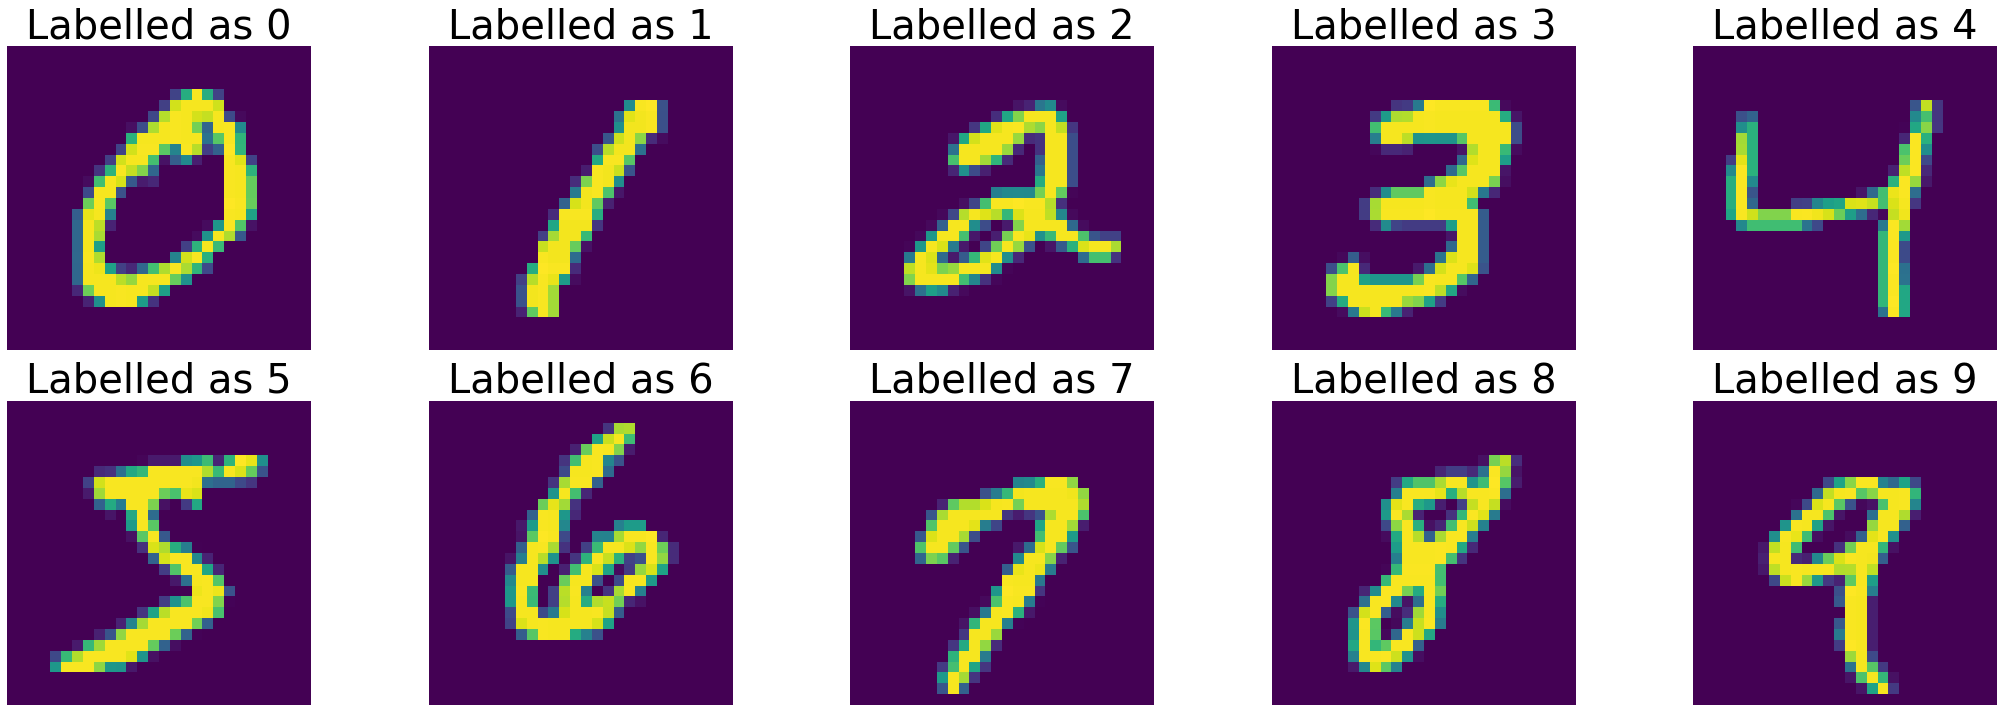

In [5]:
plt.figure(figsize=(30,10))

for idx in range(digits_no):
    index = np.where(target_mnist==idx)[0][0]
    img = data_mnist[index]
    
    plt.subplot(2,5,idx+1)
    plt.title('Labelled as %s'%(idx), fontsize=40)
    plt.imshow(img.reshape(28,28))
    plt.axis('off')

plt.tight_layout()

# Digit classification using xgboost

In [6]:
# Hyperparameters of xgb classifier
params_xgb = {'num_class': digits_no,
              'learning_rate': 0.05,
              'objective': 'multi:softprob',
              'use_label_encoder': False,
              'n_estimators': 1000}

# XGBoost setting and training
cls = xgb.XGBClassifier(**params_xgb).fit(X_train,
                                          y_train,
                                          early_stopping_rounds = 5,
                                          eval_metric = ['merror','mlogloss'],
                                          eval_set = [(X_train, y_train), (X_val, y_val)],
                                          verbose = False)

# Training metrics

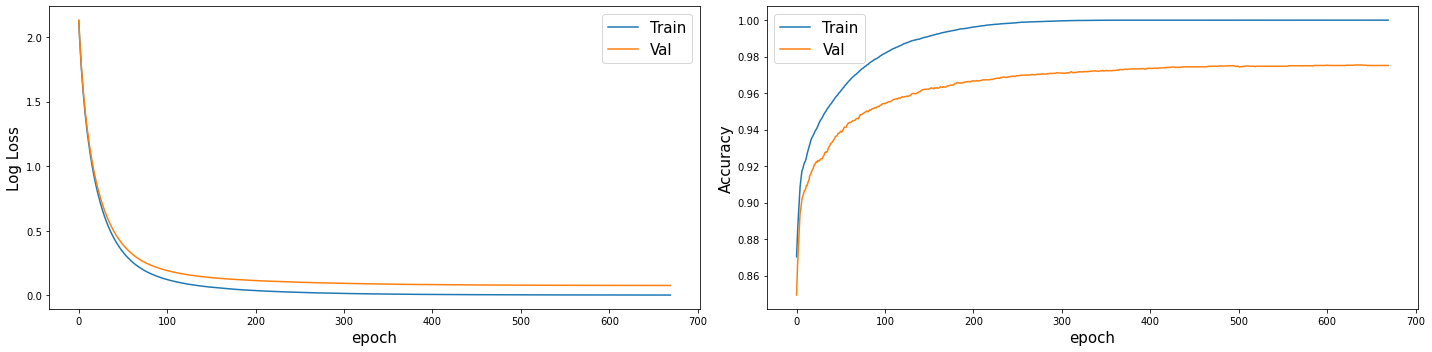

In [7]:
# Training metrics
results = cls.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('Log Loss', fontsize=15)

# Plot classification error
ax2.plot(x_axis, [1-x for x in results['validation_0']['merror']], label='Train')
ax2.plot(x_axis, [1-x for x in results['validation_1']['merror']], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()

# Evaluation

In [8]:
labels = [f'digit_{i}' for i in range(10)]
preds = cls.predict(X_test)
print(classification_report(preds, y_test, target_names=labels, digits=4))

              precision    recall  f1-score   support

     digit_0     0.9870    0.9913    0.9891       688
     digit_1     0.9898    0.9886    0.9892       789
     digit_2     0.9785    0.9785    0.9785       699
     digit_3     0.9762    0.9831    0.9796       709
     digit_4     0.9722    0.9822    0.9772       676
     digit_5     0.9810    0.9733    0.9771       636
     digit_6     0.9869    0.9826    0.9848       691
     digit_7     0.9863    0.9822    0.9843       732
     digit_8     0.9795    0.9695    0.9745       689
     digit_9     0.9640    0.9696    0.9668       691

    accuracy                         0.9803      7000
   macro avg     0.9801    0.9801    0.9801      7000
weighted avg     0.9803    0.9803    0.9803      7000



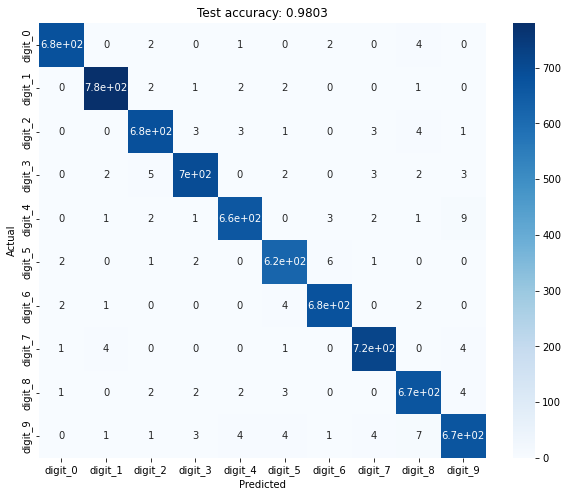

In [11]:
res = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(res, columns=labels, index = labels)
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

plt.figure(figsize = (10,8))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title('Test accuracy: %.4f' % (accuracy_score(np.squeeze(y_test), preds)))

plt.show()

# Test over sudoku tile data

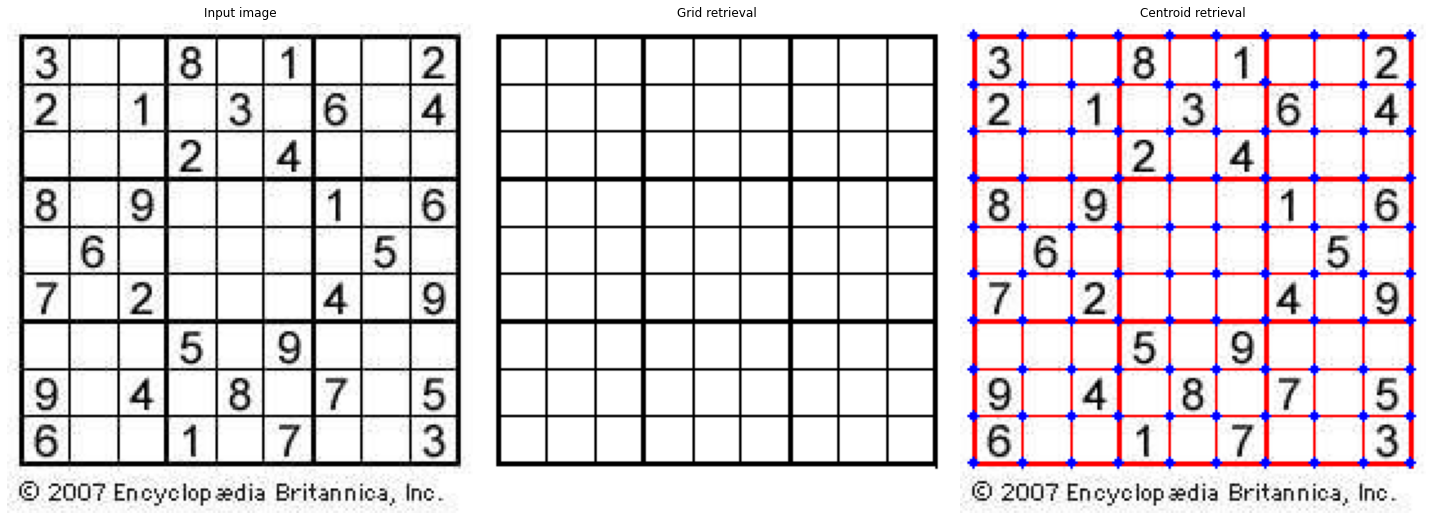

In [18]:
data = json.load(open(os.path.join(data_dir, 'clear.json')))
im_bytes = base64.b64decode(data['imageData'])
img = cv2.imdecode(np.frombuffer(im_bytes, dtype=np.uint8), flags=cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
centroid, (grid, vis), bbox = get_res(img)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Input image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(grid)
plt.title('Grid retrieval')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(vis)
plt.title('Centroid retrieval')
plt.axis('off')

plt.tight_layout()
plt.show()

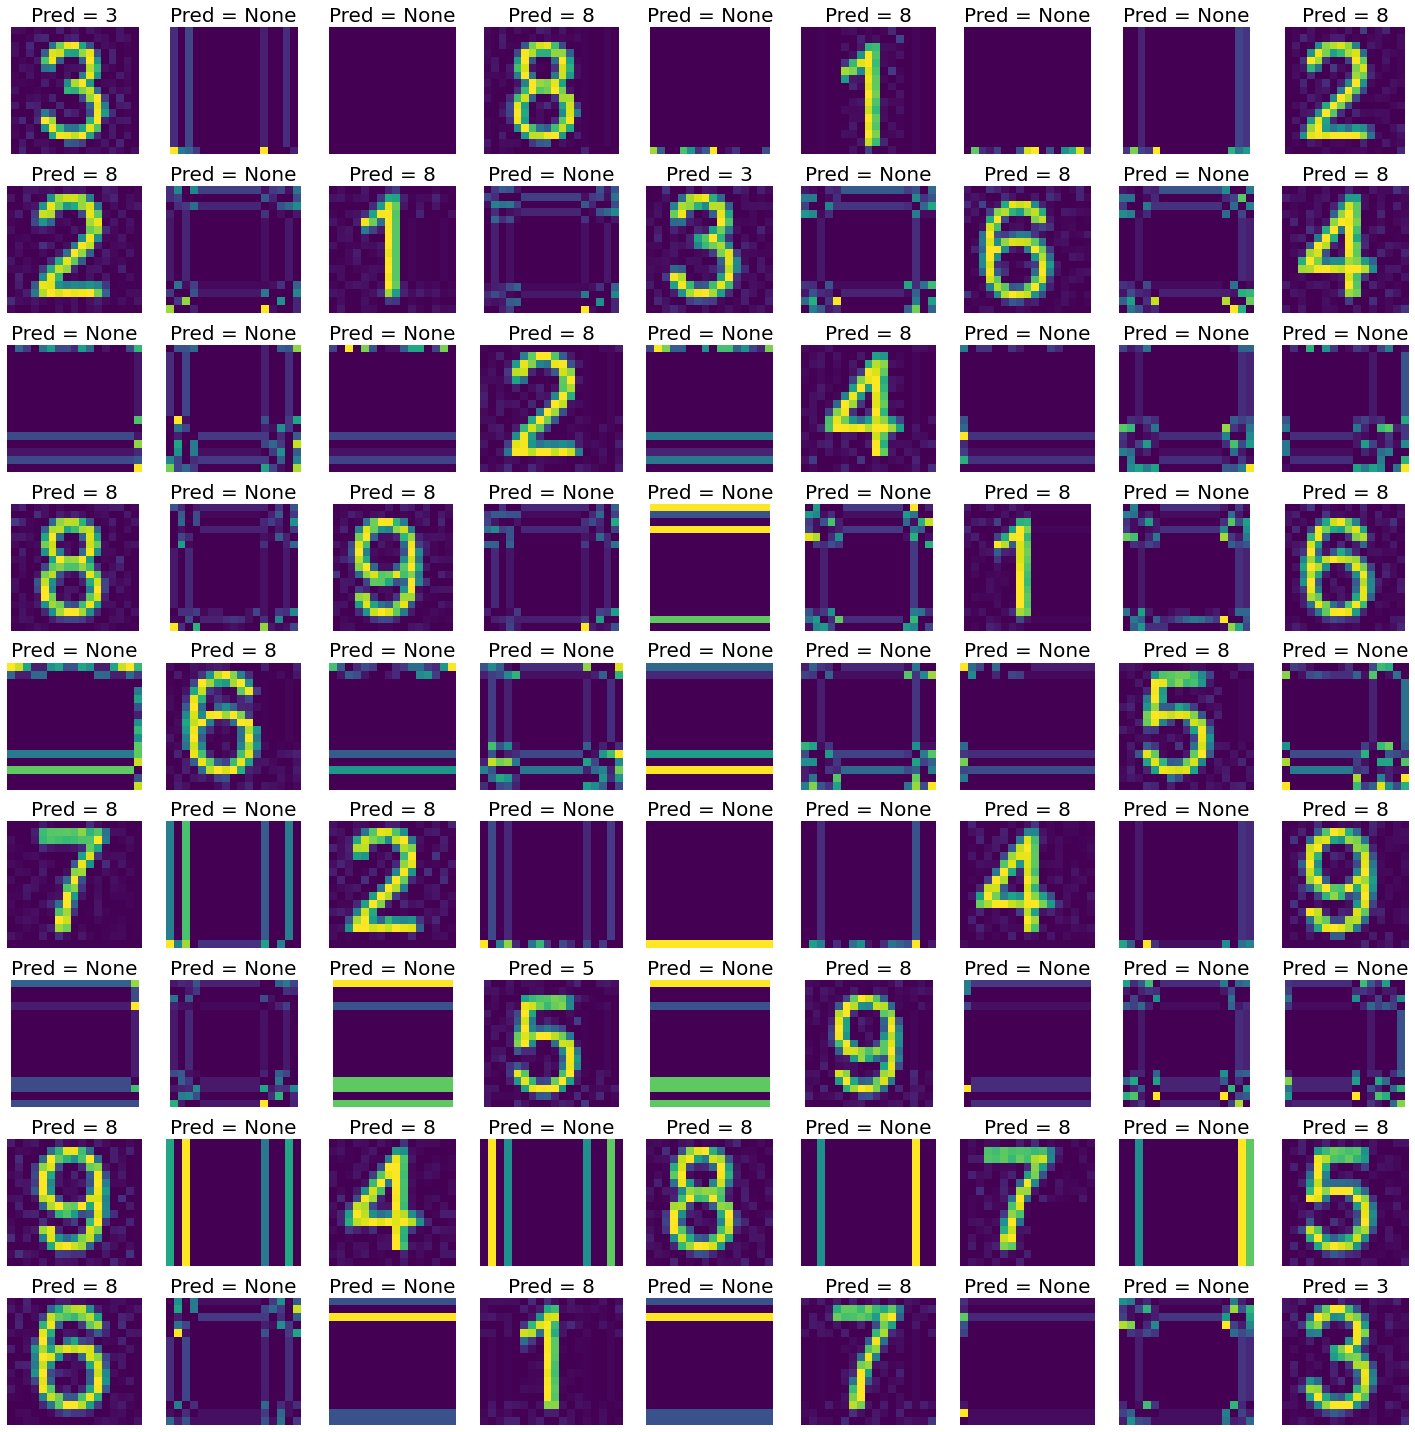

In [13]:
plt.figure(figsize=(20,20))
for idx, bb in enumerate(bbox):
    x0, x1, y0, y1 = bb
    inv = np.uint8(np.invert(gray[y0:y1,x0:x1]))
    img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR).reshape(1,-1)
    l = None if np.max(inv) < 150 else cls.predict(img_resize)[0]

    plt.subplot(9,9,idx+1)
    plt.imshow(inv)
    plt.axis('off')
    plt.title('Pred = %s'%(l),fontsize=20)

plt.tight_layout()

It appears that training on MNIST dataset does not generalize well over computer created digits and performs poorly over sudoku data.

## Data creation

In [187]:
def text_on_img(text, size=3, center=True):
    font = ['DejaVu Sans','Arial','sans-serif', 'fantasy', 'monospace', 'sans', 'sans serif', 'serif']
    
    fig, ax = plt.subplots()
    ax.text(0+uniform(0.0, 0.6 if not center else 0.25),
            0+uniform(0.0, 0.6 if not center else 0.25),
            '%s'%(text), 
            fontsize=250+randint(0,50),
            fontweight=100+randint(-50,50),
            fontname=font[randint(0,len(font)-1)])
    plt.axis('off')
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    plt.close(fig)
    
    vis = np.invert(data.reshape((int(h), int(w), -1))[:, :, [2, 1, 0]])
    vis = cv2.cvtColor(vis,cv2.COLOR_RGB2GRAY)
    vis = cv2.blur(vis,(9,9))
    vis = cv2.resize(vis,(28,28))
    
    return vis.reshape(-1,784)

In [188]:
s = 2500 # Number of datapoint to be created per digit
balance = [(idx+1,s) for idx in range(digits_no)] # Digits-volume dictionnary
data_editor = np.zeros((digits_no*s,784)) # Flatten image 28x28 pixels
target_editor = np.zeros((digits_no*s,1)) # Label data

k=0
for (key, val) in balance:
    print('Creating training data for digit %s'%(key))
    for j in tqdm(range(val), position = 0):
        data_editor[k,:] = text_on_img(str(key))
        target_editor[k,:] = np.array(key)
        k+=1
target_editor = np.squeeze(target_editor)

Creating training data for digit 1


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:55<00:00, 45.15it/s]


Creating training data for digit 2


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:53<00:00, 47.12it/s]


Creating training data for digit 3


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:55<00:00, 44.88it/s]


Creating training data for digit 4


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:55<00:00, 44.82it/s]


Creating training data for digit 5


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:57<00:00, 43.52it/s]


Creating training data for digit 6


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:27<00:00, 28.53it/s]


Creating training data for digit 7


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:59<00:00, 13.93it/s]


Creating training data for digit 8


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:54<00:00, 45.72it/s]


Creating training data for digit 9


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:20<00:00,  7.79it/s]


# Data preparation & visualization

As creating twice the amount of data for being able to recognize both handritten and editor created digits, I decided to reduce the number of data taken from MNIST as high accuracy can be expected with fewer number of datapoints.

In order to make my dataset totally balanced, I downsampled each class of MNIST dataset to 6.000 datapoints with their corresponding image and combine it with artificially created images.

In [190]:
undersample = RandomUnderSampler({i+1:s for i in list(range(digits_no))}, random_state=0)
data_mnist, target_mnist = undersample.fit_resample(data_mnist, target_mnist)

data = np.concatenate((data_editor, data_mnist), axis=0)
target = np.concatenate((target_editor, target_mnist + 10), axis=0) # +10 → Stratify mnist/editor digits categories

C:\Users\PAC\miniconda3\lib\site-packages\imblearn\utils\_validation.py:590: FutureWarning: Pass sampling_strategy={1: 2500, 2: 2500, 3: 2500, 4: 2500, 5: 2500, 6: 2500, 7: 2500, 8: 2500, 9: 2500} as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [191]:
transform = A.Compose([A.GaussianBlur((0, 5), sigma_limit=0, p=0.5),
                       A.GaussNoise(var_limit=(50, 150), p= 0.5),
                       A.ShiftScaleRotate(shift_limit=0.075,
                                          scale_limit=0.025,
                                          rotate_limit=10,
                                          interpolation=1,
                                          border_mode=0,
                                          value=(0,0,0),
                                          mask_value=0,
                                          shift_limit_x=None,
                                          shift_limit_y=None,
                                          always_apply=False,
                                          p=0.5),
                      ])
random.seed(0)
for idx, image in enumerate(tqdm(data)):
    transformed = transform(image=image.reshape(28,28).astype(np.uint8))
    data[idx,:] = np.squeeze(transformed["image"].reshape(-1,1))

C:\Users\PAC\miniconda3\lib\site-packages\albumentations\augmentations\transforms.py:1953: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
100%|██████████████████████████████████████████████████████████████████████████| 45000/45000 [00:08<00:00, 5398.97it/s]


In [192]:
X_train, X, y_train, y = train_test_split(data, target, test_size=0.2, random_state=0, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)
X_train, X_val, X_test = X_train/255, X_val/255, X_test/255

# Stratification from both handwritten and editor based should be fixed so training data contains 
# equal number of handwritten data and text-editor generated data
y_train[np.where(y_train > 9)] -= 10
y_val[np.where(y_val > 9)] -= 10
y_test[np.where(y_test > 9)] -= 10

y_train, y_val, y_test = y_train - 1, y_val - 1, y_test - 1

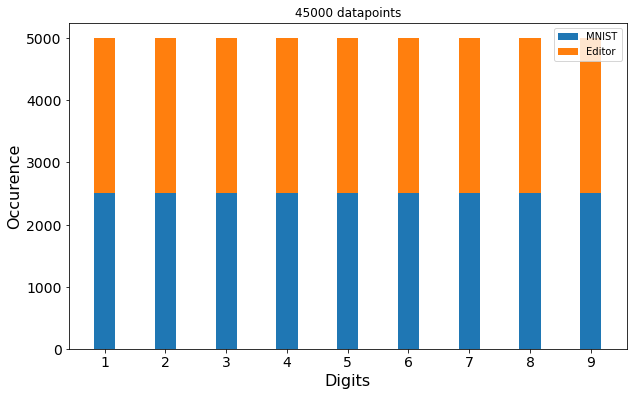

In [204]:
editor = list(Counter(target_editor).values())
mnist = list(Counter(target_mnist).values())

plt.figure(figsize=(10,6))
mnist_plot = plt.bar(np.arange(1, digits_no + 1), mnist, 0.35)
editor_plot = plt.bar(np.arange(1, digits_no + 1), editor, 0.35, bottom=mnist)

plt.tick_params(labelsize = 14)
plt.xticks(np.arange(1, digits_no + 1))
plt.xlabel("Digits", fontsize=16)
plt.ylabel('Occurence', fontsize=16)
plt.legend((mnist_plot[0], editor_plot[0]), ('MNIST', 'Editor'))
plt.title('%s datapoints'%(target.shape[0]))

plt.show()

# Train

In [205]:
# XGBoost setting and training
cls_all = xgb.XGBClassifier(**params_xgb).fit(X_train,
                                              y_train,
                                              early_stopping_rounds = 5,
                                              eval_metric = ['merror','mlogloss'],
                                              eval_set = [(X_train, y_train), (X_val, y_val)],
                                              verbose = False)
cls_all.save_model(os.path.join(model_dir,'digit_recognition.json'))

# Training metrics

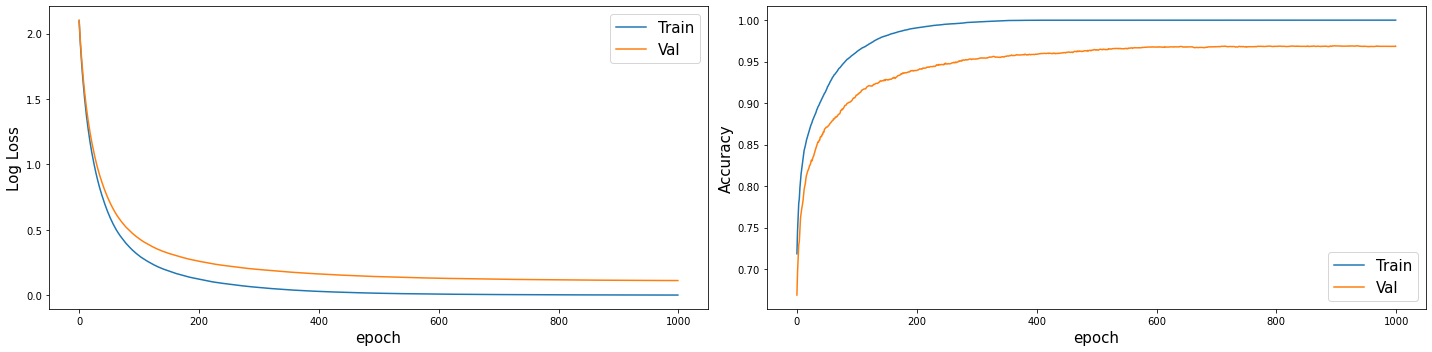

In [206]:
# Training metrics
results = cls_all.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('Log Loss', fontsize=15)

# Plot classification error
ax2.plot(x_axis, [1-x for x in results['validation_0']['merror']], label='Train')
ax2.plot(x_axis, [1-x for x in results['validation_1']['merror']], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()

## Evaluation

In [207]:
labels = [f'digit_{i+1}' for i in range(digits_no)]
preds = cls_all.predict(X_test)
print(classification_report(preds, y_test, target_names=labels, digits=4))

              precision    recall  f1-score   support

     digit_1     0.9760    0.9663    0.9711       505
     digit_2     0.9640    0.9718    0.9679       496
     digit_3     0.9560    0.9735    0.9647       491
     digit_4     0.9700    0.9566    0.9633       507
     digit_5     0.9700    0.9642    0.9671       503
     digit_6     0.9720    0.9643    0.9681       504
     digit_7     0.9660    0.9508    0.9583       508
     digit_8     0.9520    0.9616    0.9568       495
     digit_9     0.9360    0.9532    0.9445       491

    accuracy                         0.9624      4500
   macro avg     0.9624    0.9625    0.9624      4500
weighted avg     0.9626    0.9624    0.9625      4500



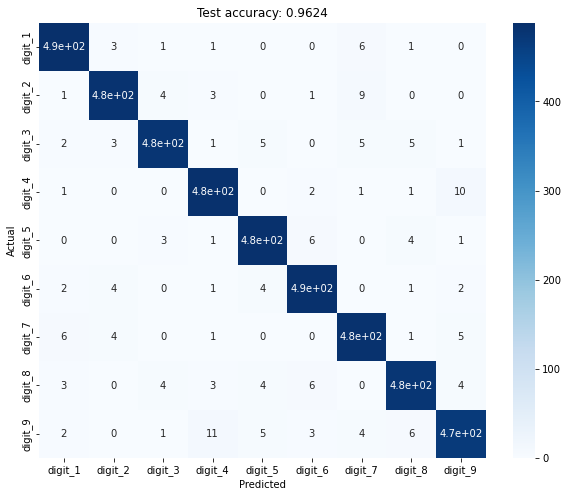

In [208]:
res = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(res, columns=labels, index = labels)
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

plt.figure(figsize = (10,8))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title('Test accuracy: %.4f' % (accuracy_score(np.squeeze(y_test), preds)))

plt.show()

# Test batch data

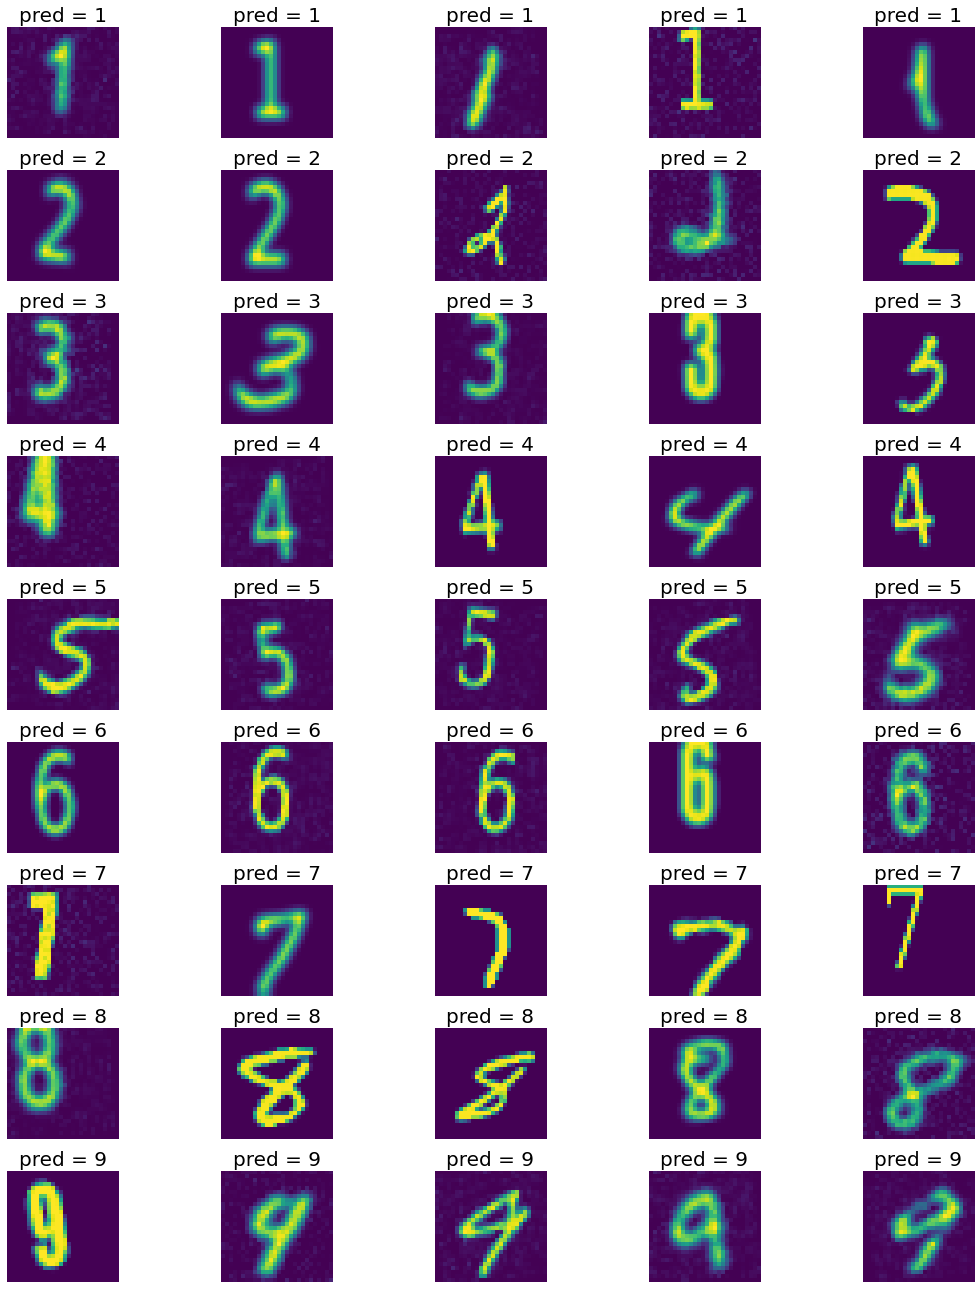

In [210]:
display_col = 5
plt.figure(figsize=(15,20))
for digit, idx in product(range(digits_no), range(display_col)):
    img = X_test[np.where(y_test==digit)[0][idx]]
    pred = int(cls_all.predict(img.reshape(1,-1))[0])
    
    plt.subplot(digits_no + 1, display_col, digit*display_col + idx + 1)
    plt.title('pred = %s'%(pred + 1), fontsize=20)
    plt.imshow(img.reshape(28,28))
    plt.axis('off')

plt.tight_layout()

# Visualization over sudoku data

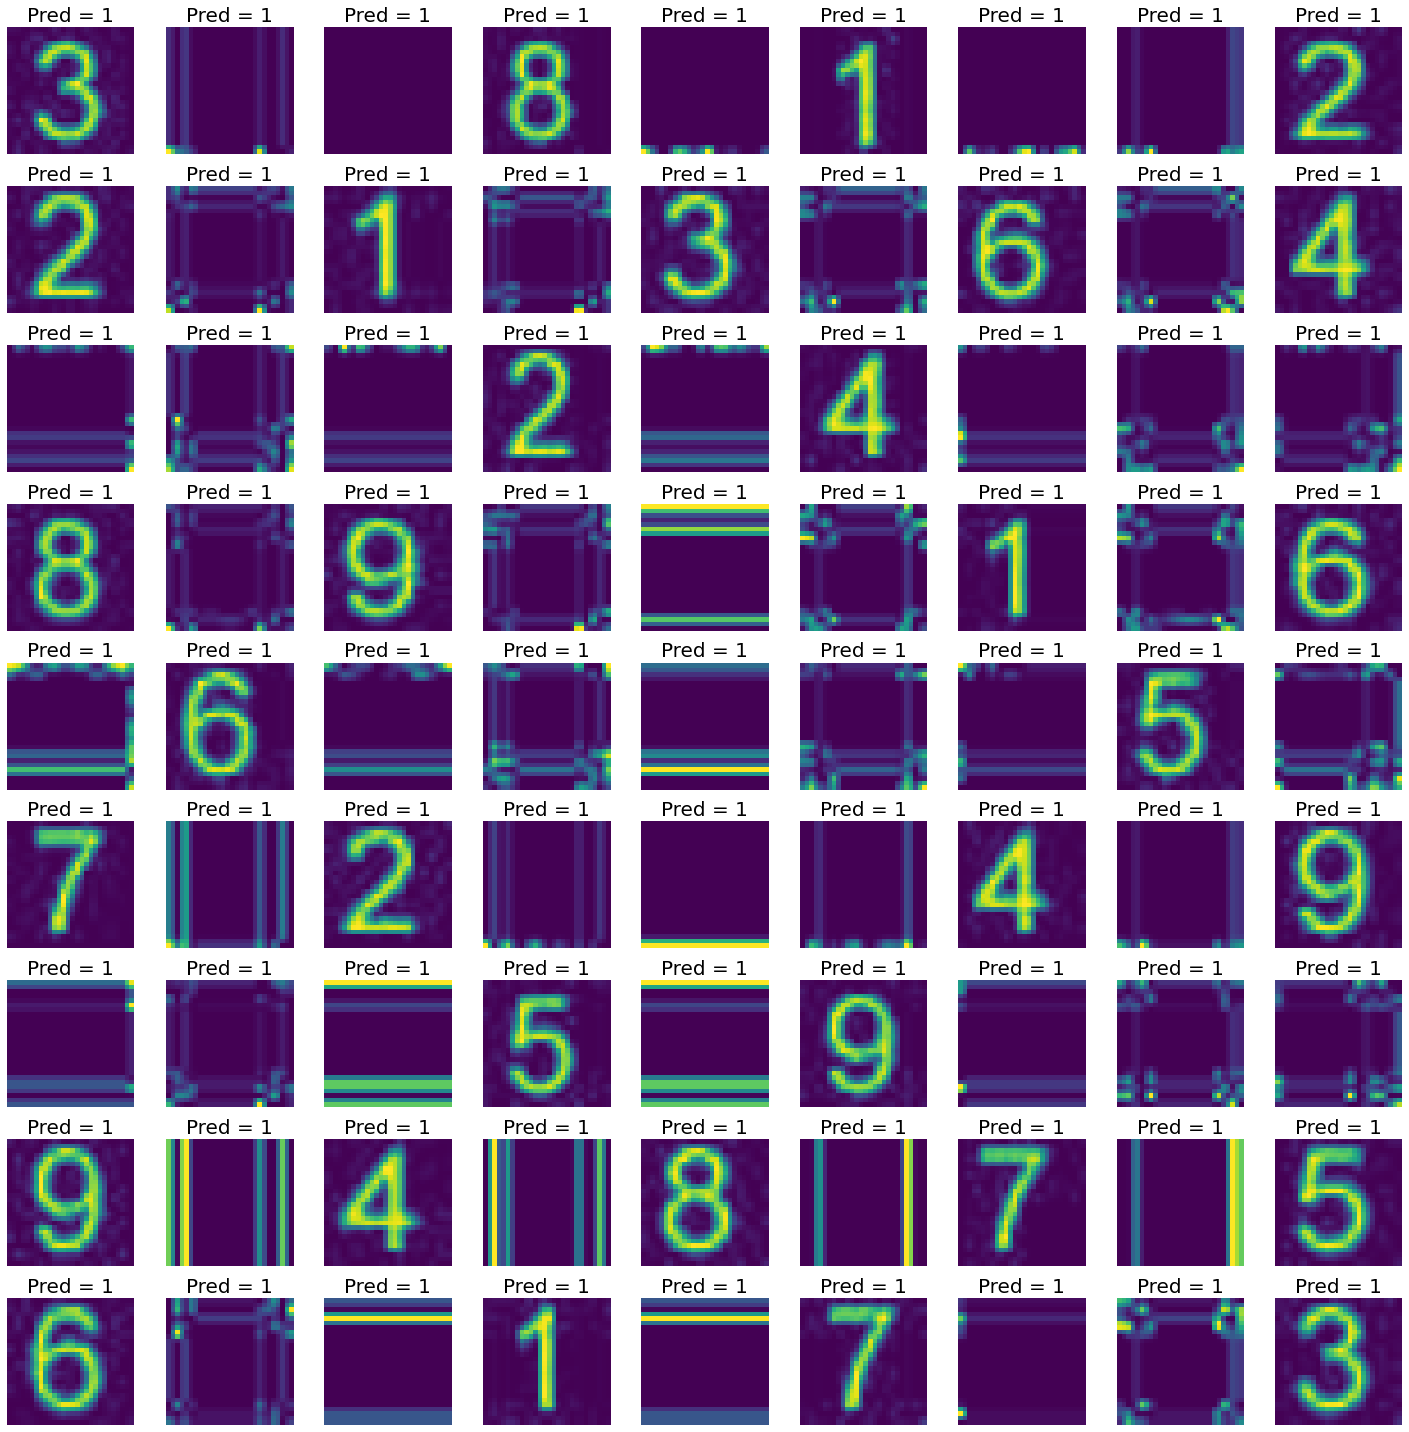

In [211]:
plt.figure(figsize=(20,20))
for idx, bb in enumerate(bbox):
    x0, x1, y0, y1 = bb
    inv = np.invert(gray[y0:y1,x0:x1]) / np.max(gray)
    img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR)
    l = None if np.max(gray) < 150 else int(cls_all.predict(img_resize.reshape(1,-1).astype(int))[0])
    
    plt.subplot(9,9,idx+1)
    plt.imshow(img_resize)
    plt.axis('off')
    plt.title('Pred = %s'%(l + 1),fontsize=20)

plt.tight_layout()

In [ ]:
# x0, x1, y0, y1 = bbox[3]
# inv = np.uint8(np.invert(gray[y0:y1,x0:x1]))
# print(np.max(inv))

# img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR)
# # img_resize = cv2.morphologyEx(img_resize, cv2.MORPH_OPEN, (5,5))
# # img_resize = cv2.adaptiveThreshold(np.invert(img_resize), 250, 1, 1, 11, 2)

# print(cls_all.predict(img_resize.reshape(1,-1).astype(int)))
# plt.imshow(img_resize)